In [1]:
import numpy as np
import pandas as pd
import os
import torch
from torch import nn
from torchvision import models, transforms
from torch.nn.functional import mse_loss
from PIL import Image
import matplotlib.pyplot as plt


In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [3]:
#Image size
H=128
W=128

Loading images

In [4]:
rgb_mean = torch.tensor([0.485, 0.456, 0.406])
rgb_std = torch.tensor([0.229, 0.224, 0.225])
transform=transforms.Compose([
    transforms.Resize((H,W)),
    transforms.ToTensor(),
    transforms.Normalize(mean=rgb_mean, std=rgb_std)
])

In [5]:
content_img=Image.open('content.jpg')
content_trans=transform(content_img)

In [6]:
style_img=Image.open('style3.jpg')
style_trans=transform(style_img)

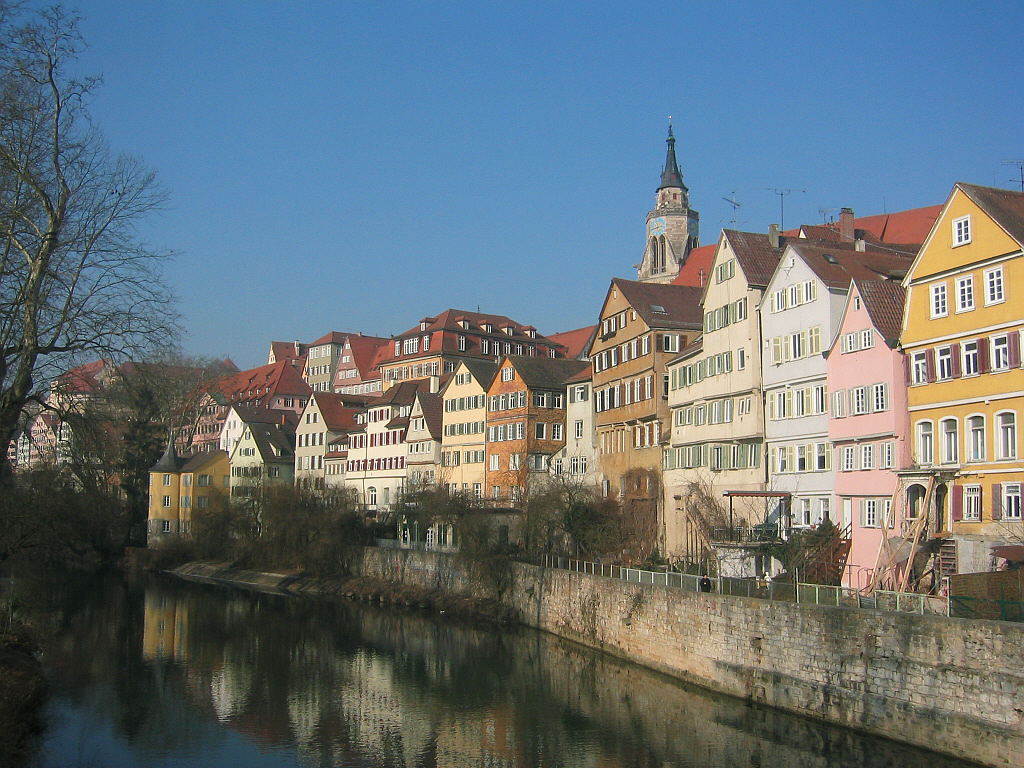

In [7]:
content_img

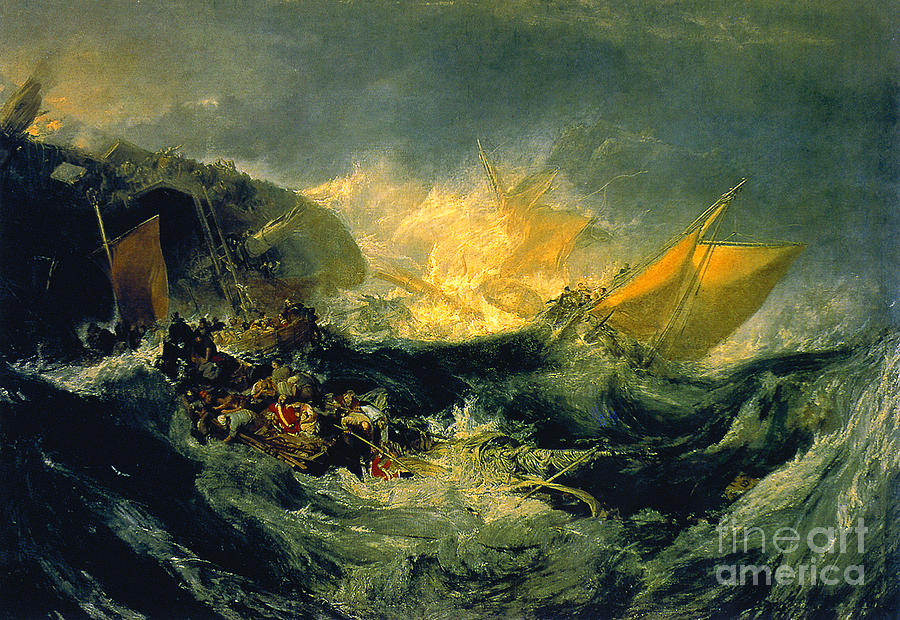

In [8]:
style_img

In [9]:
content_input=torch.unsqueeze(content_trans,0)
style_input=torch.unsqueeze(style_trans,0)#.to(device)

VGG 19 network

In [10]:
#Loading model
model=models.vgg19(pretrained=True)#.to(device)

/home/phong/miniconda3/envs/mlenv/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/phong/miniconda3/envs/mlenv/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [12]:
model=model.to(device)
model.features

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (17): ReLU(inplace=True)
  (18): MaxPoo

In [13]:
#Replace MaxPool by AvgPool
for i, layer in enumerate(model.features):
    if isinstance(layer, torch.nn.MaxPool2d):
        model.features[i]=torch.nn.AvgPool2d(kernel_size=2, stride=2, padding=0)

In [15]:
model.features[25]

Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))

### Extract features

In [16]:
#List of using layers
content_layers=[28]
style_layers=[0, 5, 10, 19, 28 ]
layer_idx=max(content_layers+style_layers)+1

In [17]:
#Extract features
def extract_features(model, X, with_grad):
  if with_grad:
    contents=[]
    styles=[]
    for i in range(layer_idx):
      X=model.features[i](X)
      if i in content_layers:
        contents.append(X)
      if i in style_layers:
        styles.append(X)
    return contents, styles
  else:
    with torch.no_grad():
      contents=[]
      styles=[]
      for i in range(layer_idx):
        X=model.features[i](X)
        if i in content_layers:
          contents.append(X)
        if i in style_layers:
          styles.append(X)
      return contents, styles


In [18]:
#Content features and style features
content_features,_=extract_features(model, content_input.to(device), False)
_,style_features=extract_features(model, style_input.to(device), False)

In [19]:
print(content_features[0].size())
print(style_features[4].size())

torch.Size([1, 512, 8, 8])
torch.Size([1, 512, 8, 8])


Gram matrix

In [20]:
#Gram matrix
def Gram_matrix(tensor):
  _,c,h,w=tensor.size()
  dim=h*w
  matrix=tensor.view(c, dim)
  gram_matrix=torch.mm(matrix, matrix.t())
  return gram_matrix/(c*dim)
style_gram_matrix=[Gram_matrix(x) for x in style_features]

Training

In [22]:
#Parameters
weights=torch.tensor([0.8,0.6,0.4,0.2,0.1]) #weights of layers
alpha=1
beta=1e5
target=content_input.clone().requires_grad_(True)#.to(device)

In [23]:
#Optimization
opt=torch.optim.Adam([target], lr=0.02)

In [24]:
#training model
resultat=[]
Loss=[]
for i in range(101):
  #Gradient_zero
  opt.zero_grad()
  #Target features
  target_content, target_style=extract_features(model, target.to(device), True) #Caculate the target_content and target_style
  #Forward
  content_loss=nn.functional.mse_loss(content_features[0], target_content[0])  #Content loss
  target_gram_matrix=[Gram_matrix(x) for x in target_style]  #Gram matrix of target style
  style_loss=0
  for w in range(len(weights)):
    layer_loss=nn.functional.mse_loss(style_gram_matrix[w], target_gram_matrix[w])*weights[w] #Style loss with weights
    style_loss+=layer_loss
  total_loss=alpha*content_loss+beta*style_loss #Total loss
  #Backward
  total_loss.backward()
  #Update
  opt.step()
  Loss.append(total_loss.item())
  if i%10==0:
    resultat.append(target)
    print(f'Iteration {i}, Content loss {content_loss}, Style loss {style_loss}, Total loss {total_loss}.')



Iteration 0, Content loss 0.0, Style loss 5.250013600743841e-06, Total loss 0.5250013470649719.
Iteration 10, Content loss 0.011968451552093029, Style loss 2.4581736397522036e-06, Total loss 0.257785826921463.
Iteration 20, Content loss 0.009358325973153114, Style loss 1.430322413398244e-06, Total loss 0.15239056944847107.
Iteration 30, Content loss 0.00763089582324028, Style loss 9.687751116871368e-07, Total loss 0.1045083999633789.
Iteration 40, Content loss 0.006602134555578232, Style loss 7.401669677165046e-07, Total loss 0.08061882853507996.
Iteration 50, Content loss 0.005823432467877865, Style loss 6.133065539870586e-07, Total loss 0.06715408712625504.
Iteration 60, Content loss 0.005406522192060947, Style loss 5.310228630150959e-07, Total loss 0.05850880593061447.
Iteration 70, Content loss 0.005134312901645899, Style loss 4.722158735148696e-07, Total loss 0.05235590040683746.
Iteration 80, Content loss 0.004868214949965477, Style loss 4.2854088633248466e-07, Total loss 0.04772

In [25]:
def show_target(tensor):
  #tensor=tensor.cpu()
  img=tensor.squeeze()
  img=img.detach().numpy()
  img=img.transpose(1,2,0)
  img = img*np.array(rgb_std) + np.array(rgb_mean)
  img = img.clip(0, 1)
  return img


/tmp/ipykernel_41635/1174023165.py:6: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  img = img*np.array(rgb_std) + np.array(rgb_mean)


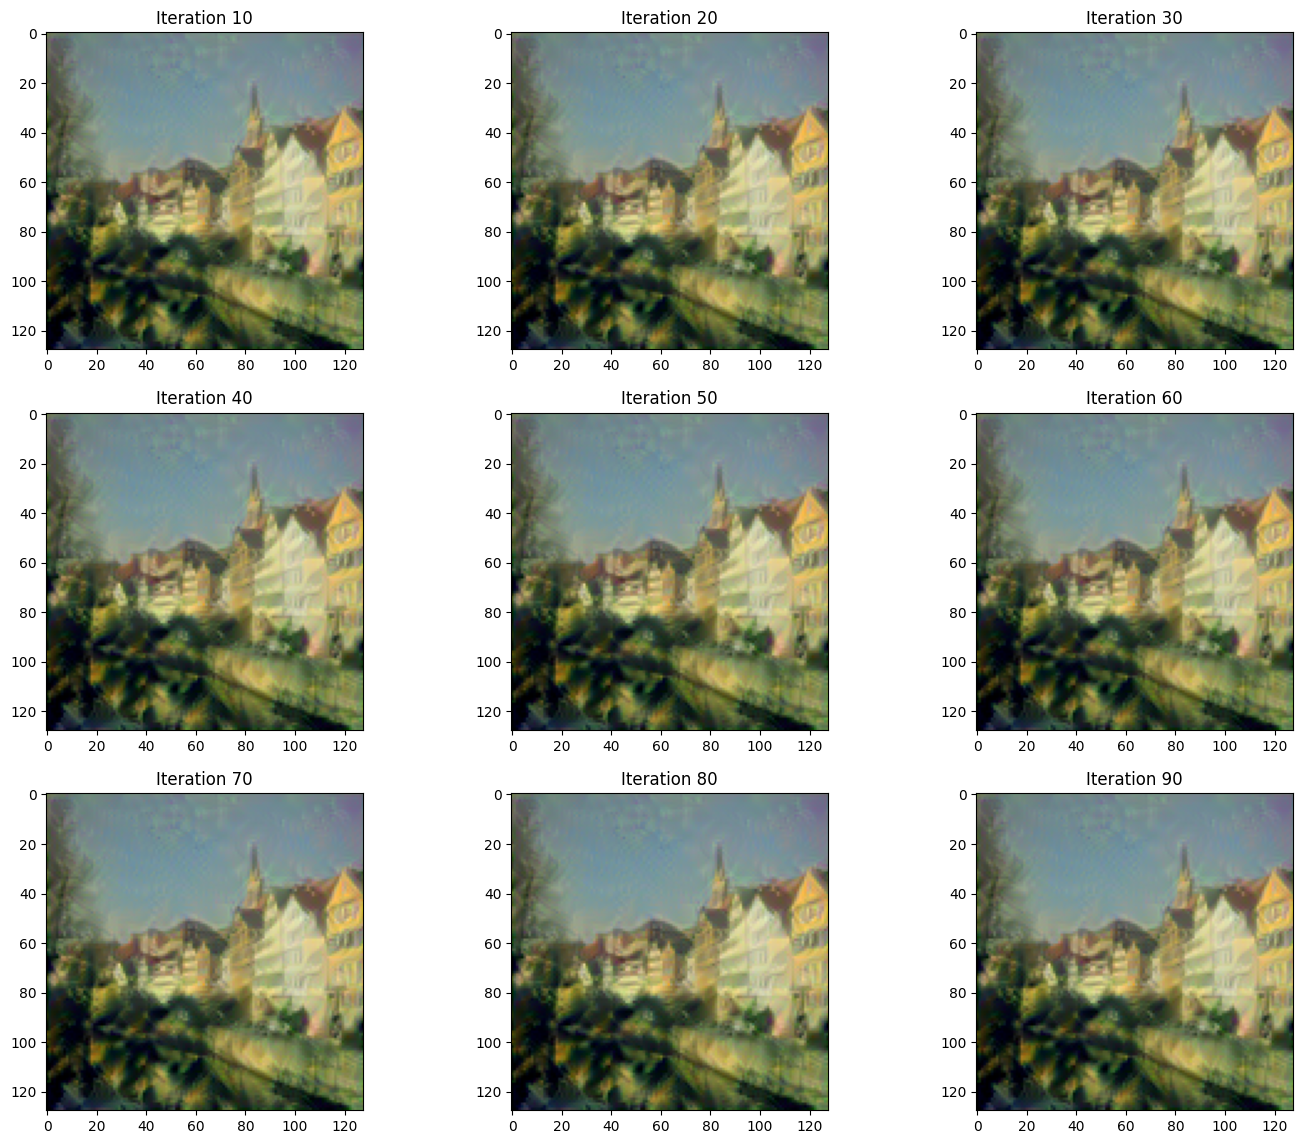

In [27]:
plt.figure(figsize=(17,14))
for i in range(1,len(resultat)-1):
  plt.subplot(3,3,i)
  plt.imshow(show_target(resultat[i]))
  plt.title(f'Iteration {10*i}')

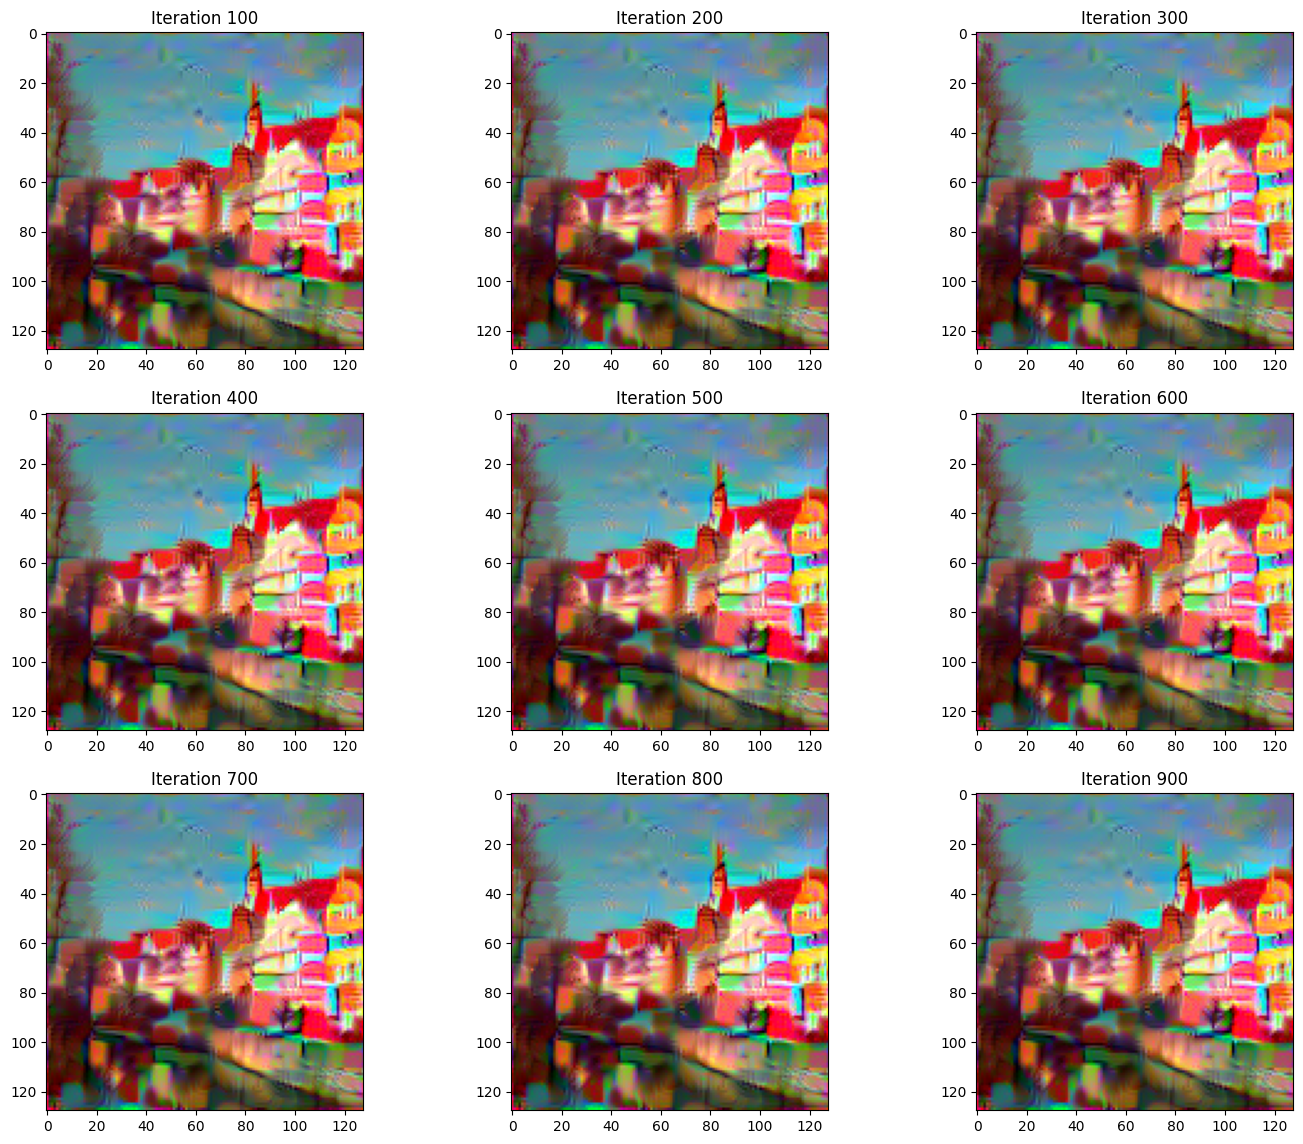

In [ ]:
plt.figure(figsize=(17,14))
for i in range(1,len(resultat)-1):
  plt.subplot(3,3,i)
  plt.imshow(show_target(resultat[i]))
  plt.title(f'Iteration {100*i}')

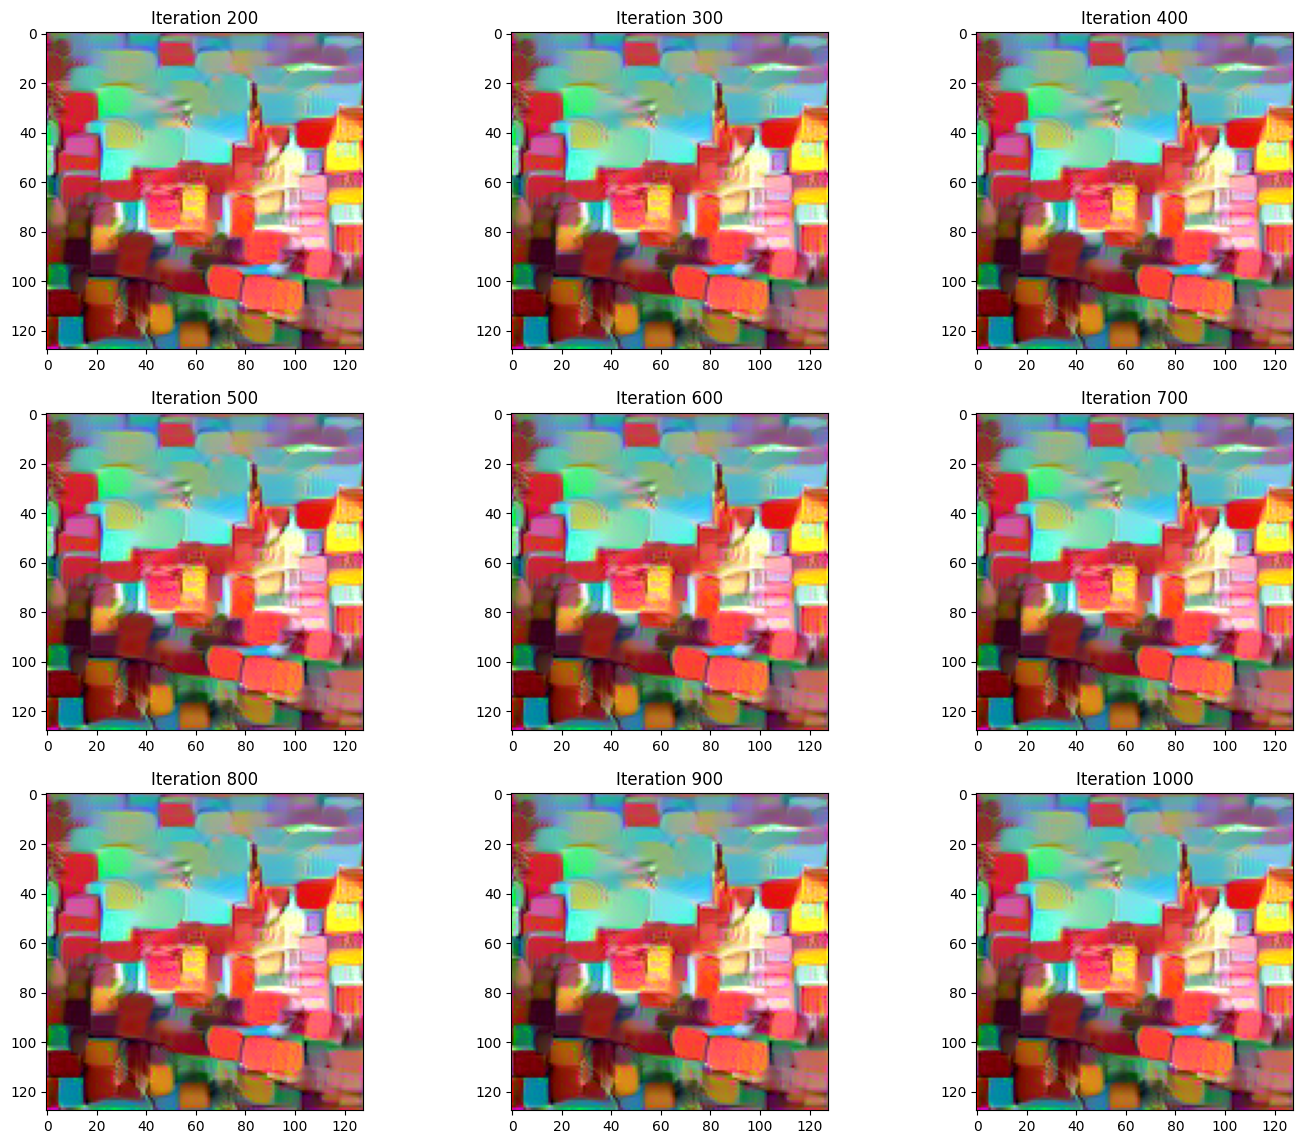

In [ ]:
plt.figure(figsize=(17,14))
for i in range(1,len(resultat)-1):
  plt.subplot(3,3,i)
  plt.imshow(show_target(resultat[i]))
  plt.title(f'Iteration {100*i}')

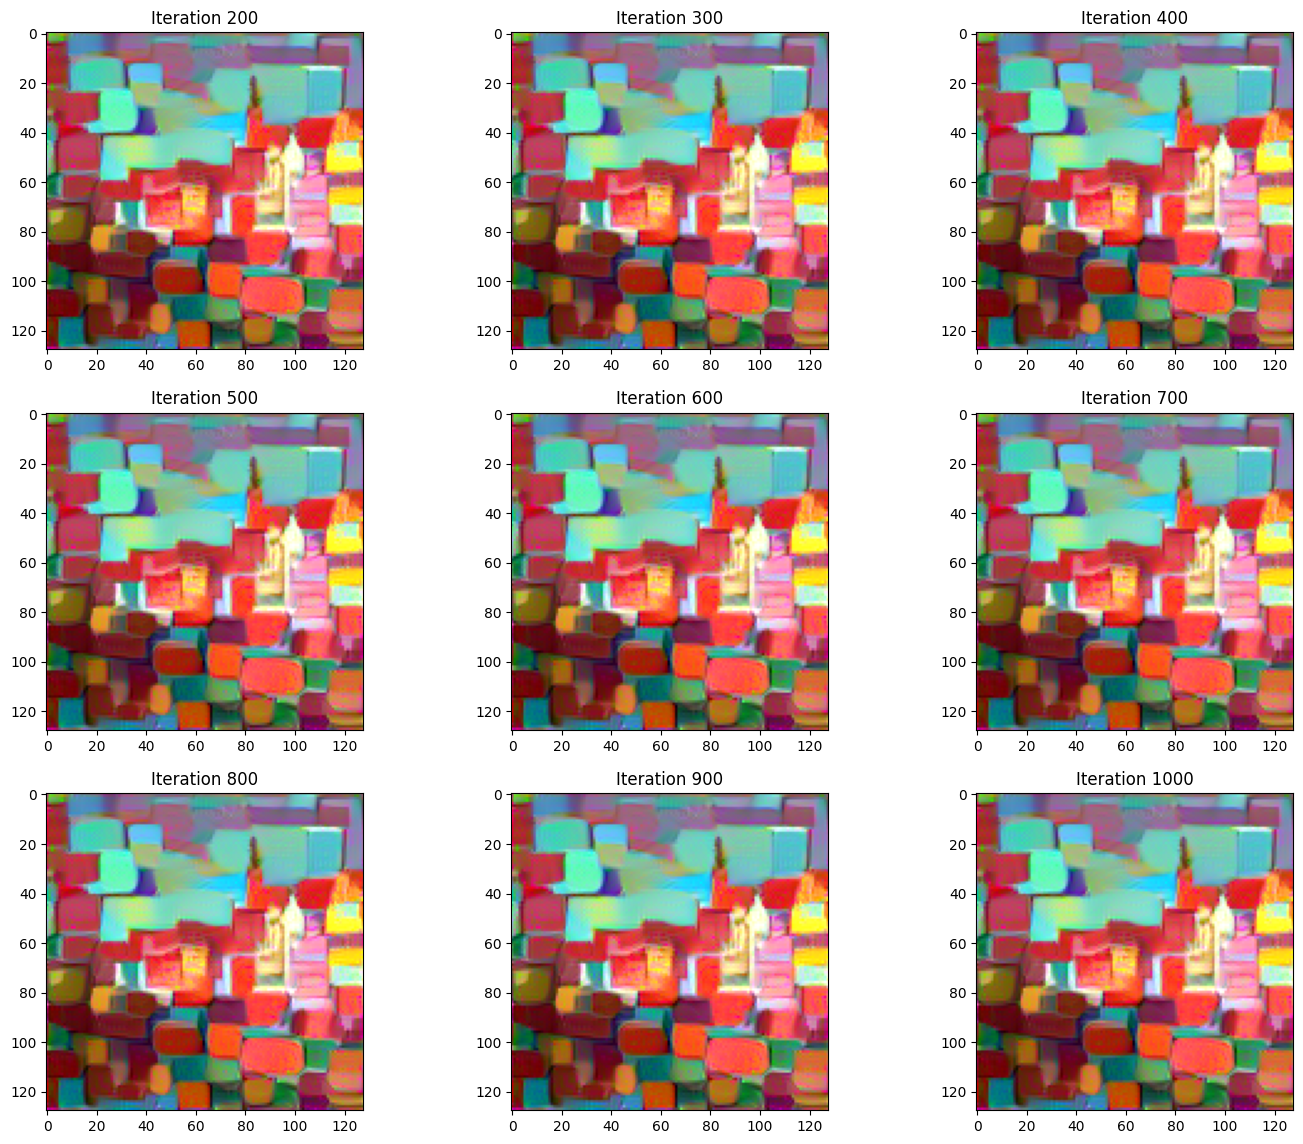

In [ ]:
plt.figure(figsize=(17,14))
for i in range(2,len(resultat)):
  plt.subplot(3,3,i-1)
  plt.imshow(show_target(resultat[i]))
  plt.title(f'Iteration {100*i}')

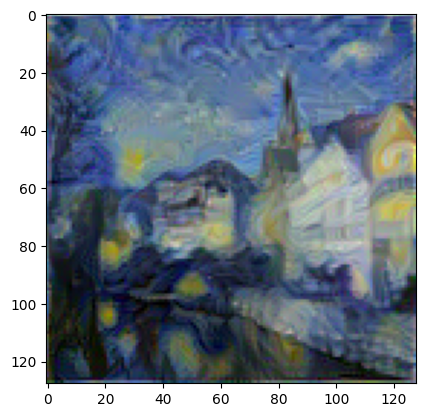

In [ ]:
plt.imshow(show_target(resultat[10]))

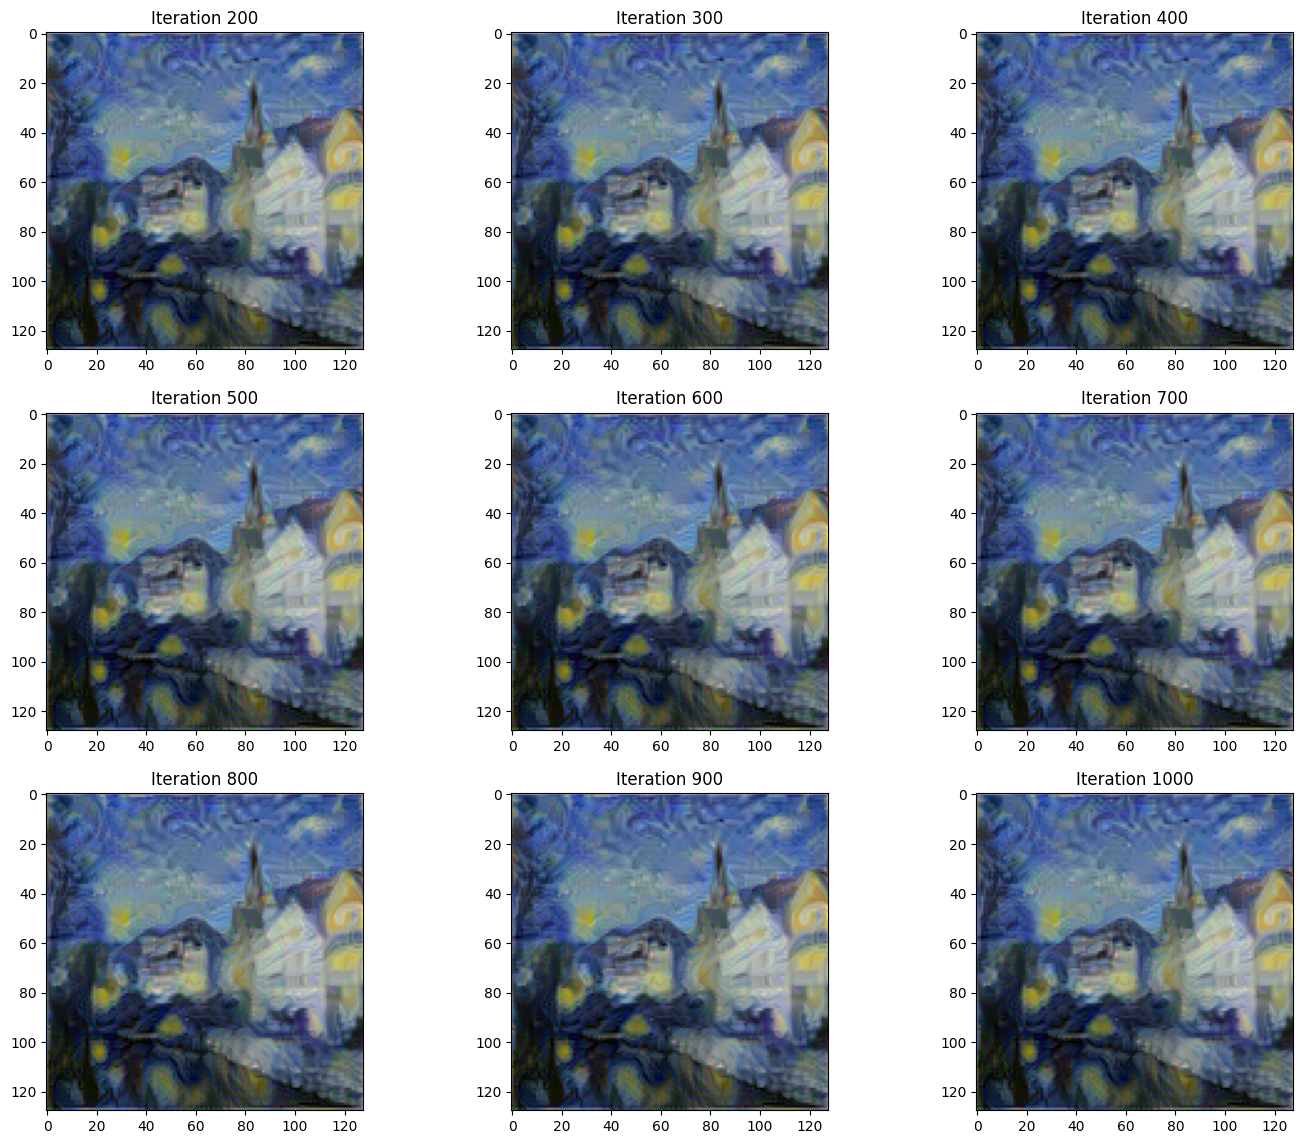

In [ ]:
plt.figure(figsize=(17,14))
for i in range(2,len(resultat)):
  plt.subplot(3,3,i-1)
  plt.imshow(show_target(resultat[i]))
  plt.title(f'Iteration {100*i}')

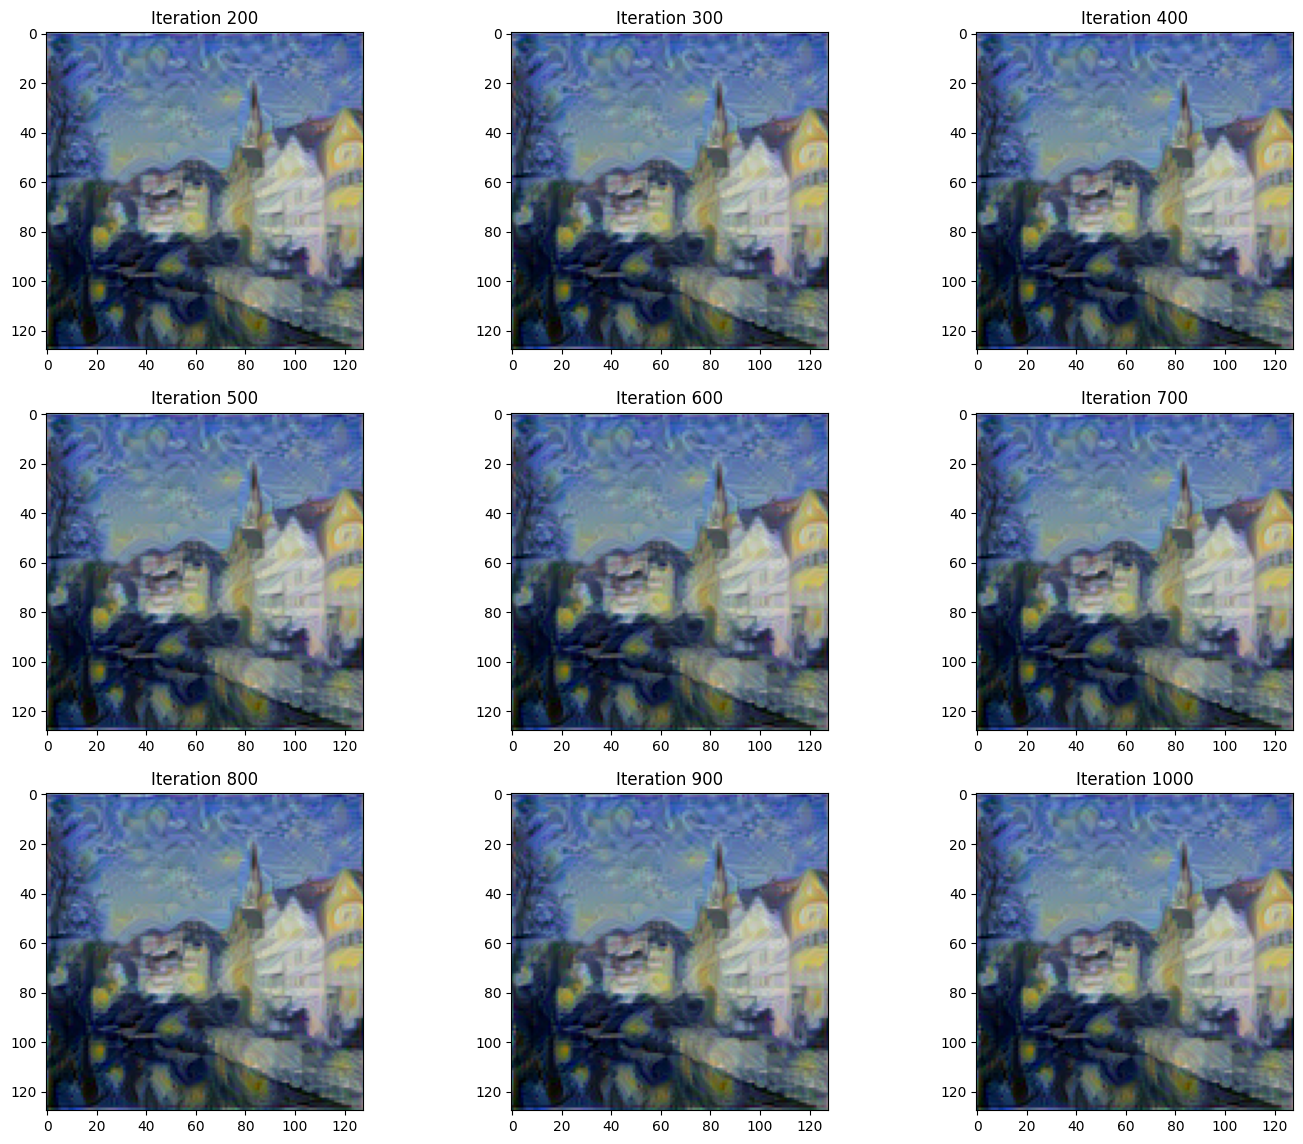

In [ ]:
plt.figure(figsize=(17,14))
for i in range(2,len(resultat)):
  plt.subplot(3,3,i-1)
  plt.imshow(show_target(resultat[i]))
  plt.title(f'Iteration {100*i}')